In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import subprocess

from scipy.interpolate import RectBivariateSpline

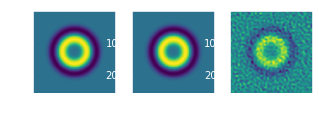

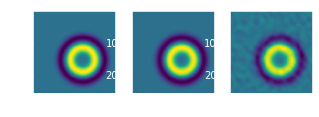

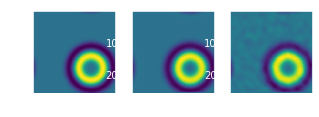

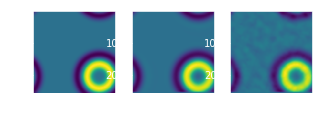

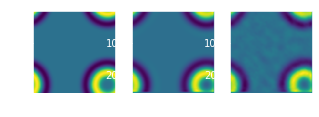

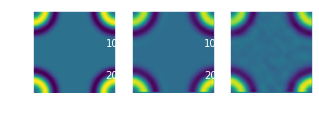

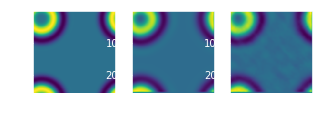

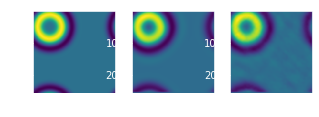

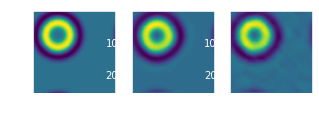

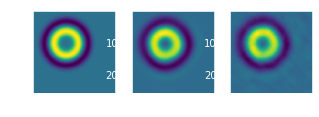

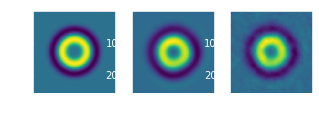

In [134]:
py_directory = "./"
py_directory += "output_travelling_vortex_3d_48/"

inner = (slice(2,-2),slice(2,-2))

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

# def py_out_ensemble(pyfile,py_dataset,time):
#     return pyfile[str(py_dataset)][str(py_dataset)][time][:]


def test_case(time, path):
    file = h5py.File(path,'r')
    
    t_label = '_' + str(time) + '_' + 'after_full_step'
    rho = py_out(file,'vortz',time=t_label)[inner]

    file.close()
    return rho

def ensemble_test_case(time, path, N):
    file = h5py.File(path,'r')
    
    rho = []
    for n in range(N):
        t_label = '_ensemble_mem=' + str(n) + '_' + str(time) + '_' + 'after_full_step'
        rho.append(py_out(file,'vortz',time=t_label)[inner])

    rho = np.array(rho)
    rho = rho.mean(axis=0)

    file.close()
    return rho

py_filename_ref = "output_travelling_vortex_3d_48_low_mach_gravity_comp_256_256.h5"
py_path_ref = get_path(py_filename_ref)

py_filename_48 = "output_travelling_vortex_3d_48_low_mach_gravity_comp_48_48.h5"
py_path_48 = get_path(py_filename_48)

py_filename_ens = "output_travelling_vortex_3d_48_low_mach_gravity_comp_48_ensemble=20.h5"
py_path_ens = get_path(py_filename_ens)

comp_ref = test_case(0.0,py_path_ref)
ref_x = np.linspace(-0.5,0.5,comp_ref.shape[0])
ref_x, ref_y = np.meshgrid(ref_x,ref_x)

N = 20
# comp_ens = ensemble_test_case(time,py_path_ens,N)
# print(comp_ens.shape)

times = np.arange(0,11) / 10
# times = [0.0]
rmse_48, rmse_ens = [], []

for time in times:
    comp_ref = test_case(time, py_path_ref)
    comp_48 = test_case(time, py_path_48)
    x = np.linspace(-0.5,0.5,comp_48.shape[0])
    interpolate = RectBivariateSpline(x,x,comp_48)
    comp_48 = interpolate.ev(ref_x,ref_y)
    comp_ens = ensemble_test_case(time,py_path_ens,N)
    interpolate = RectBivariateSpline(x,x,comp_ens)
    comp_ens = interpolate.ev(ref_x,ref_y)

    rmse_48.append(spatially_averaged_rmse(comp_48,comp_ref))
    rmse_ens.append(spatially_averaged_rmse(comp_ens,comp_ref))

    fig = plt.figure(figsize=(5,3))
    ax0 = fig.add_subplot(1,3,1)
    ax0.imshow(comp_ref)
    ax1 = fig.add_subplot(1,3,2)
    ax1.imshow(comp_48)
    ax2 = fig.add_subplot(1,3,3)
    ax2.imshow(comp_ens)
    plt.show()

plt.figure()
plt.plot(times,rmse_48, label='48')
plt.plot(times,rmse_ens, label='ens')
plt.legend()
plt.show()

In [62]:
def spatially_averaged_rmse(arr,ref):
    n,m = ref.shape
    N = n * m
    return (((arr - ref)**2).sum() / N)**0.5

rmse = spatially_averaged_rmse(comp_48,comp_ref)
print(rmse)
var = rmse**2
print(var)

0.7618548038542867
0.5804227421558537
